In [1]:
import quandl
import pandas as pd
import pickle

In [2]:
df = quandl.get("WIKI/GOOGL")
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [3]:
df = df[["Adj. Open", "Adj. High", "Adj. Low", "Adj. Close", "Adj. Volume"]]
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [4]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [5]:
df = df[["Adj. Close", "HL_PCT", "PCT_change", "Adj. Volume"]]
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0
2004-08-20,54.322689,7.921706,7.227007,22834300.0
2004-08-23,54.869377,4.049360,-1.227880,18256100.0
2004-08-24,52.597363,7.657099,-5.726357,15247300.0
2004-08-25,53.164113,3.886792,1.183658,9188600.0


In [6]:
forecast_col = "Adj. Close"
df.fillna(-99999, inplace=True)
import math
forecast_out = int(math.ceil(0.01*len(df)))

In [7]:
df["label"] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)
df.head()
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2018-01-30,1177.37,1.139829,-0.029718,1792602.0,1094.00
2018-01-31,1182.22,1.202822,-0.134312,1643877.0,1053.15
2018-02-01,1181.59,1.530988,0.476195,2774967.0,1026.55
2018-02-02,1119.20,1.798606,-0.729098,5798880.0,1054.09
2018-02-05,1068.76,5.450241,-2.893850,3742469.0,1006.94


In [8]:
import numpy as np
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'][:-forecast_out])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

with open('LinearRegression.pickle', 'wb') as f:
    pickle.dump(clf, f)

confidence = clf.score(X_test, y_test)
print(confidence)

0.9764821234123053


In [9]:
forecast_set = clf.predict(X_lately)
print(forecast_set, confidence, forecast_out)

[1080.78441556 1094.91082515 1108.59478326 1103.62998824 1097.30338307
 1094.94848471 1093.38920274 1089.79608376 1084.07735631 1079.63486085
 1077.49992543 1095.82589048 1114.49278678 1120.09654963 1134.57875903
 1138.90380248 1137.37690108 1134.83511849 1136.64080487 1154.10801195
 1154.48655271 1163.58936044 1160.43014258 1168.39171859 1188.18255161
 1201.46248935 1195.96917529 1207.53096126 1212.38121345 1211.85898966
 1202.56121454 1207.47733322 1206.15981637 1141.79129608 1087.97317942] 0.9764821234123053 35


In [10]:
import math, datetime
import matplotlib.pyplot as plt
from matplotlib import style

In [11]:
style.use("ggplot")

df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

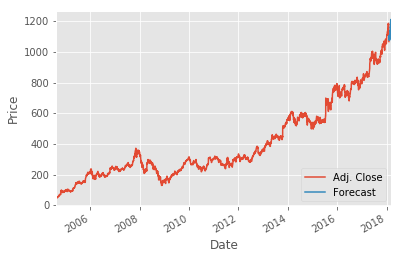

In [12]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()